# Quickstart Example with Synthetic Simulation (Customization)
This notebook provides an example of customizing the synthetic environment.

This example on the Synthetic Simulation consists of the following 3 steps:
1. Setup Synthetic Environment and Interacting Online RL Agent
2. Standardized Environment
3. Customize Environmental Configuration

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  

In [634]:
# delete later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [635]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [636]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [637]:
# import OFRL modules
import ofrl
from ofrl.policy import OnlineHead
from ofrl.policy import DiscreteEpsilonGreedyHead

# import synthetic modules
# import synthetic
from syntheticgym import SyntheticEnv
from syntheticgym import RewardFunction
from syntheticgym import StateTransition
from syntheticgym import BaseRewardFunction
from syntheticgym import BaseStateTransition

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import gym

from sklearn.utils import check_random_state
from sklearn.utils import check_scalar

In [638]:
from dataclasses import dataclass
from typing import Tuple, Union, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [639]:
# version
print(ofrl.__version__)

0.0.0


In [640]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

## 1. Setup Synthetic Environment and Interacting Online RL Agent
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for Synthetic
In synthetic , the objective of the RL agent is to maximize reward

We often formulate this synthetic  problem as the following (Partially Observable) Markov Decision Process ((PO)MDP):
- `state`: 
   - When the true state is unobservable, you can gain observation instead of state.
- `action`:  Index of an action to present to the context.
- `reward`: Either binary or continuous.

Let's see how it works!

In [641]:
# setup environment
env = SyntheticEnv(action_type='continuous', random_state=random_state)

In [642]:
# define a random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    ),
    name="random",
)
agent.build_with_env(env)

In [643]:
print(agent)
print(env.action_space)
print(env.observation_space)

OnlineHead(base_policy=d3rlpy.algos.random_policy.RandomPolicy(action_scaler=d3rlpy.preprocessing.action_scalers.MinMaxActionScaler(minimum=0.1, maximum=10), action_size=3, batch_size=1, distribution='uniform', gamma=0.0, generated_maxlen=100000, impl=None, n_frames=1, n_steps=1, normal_std=1.0, real_ratio=1.0, reward_scaler=None, scaler=None), name='random')
Box(-0.1, 10.0, (3,), float64)
Box(-inf, inf, (5,), float64)


In [644]:
import ofrl
from ofrl.ope.online import calc_on_policy_policy_value
# calculate on-policy policy value
on_policy_performance = calc_on_policy_policy_value(
  env,
  agent,
  n_trajectories=100,
  random_state=12345
)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [645]:
print(on_policy_performance)

28.015213305333077


In [646]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info = env.reset()
    done = False

    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [647]:
# state 
print(obs.shape)
print(obs)

(5,)
[ 0.00987027 -0.44329176 -0.36035872 -0.77317723  0.27519731]


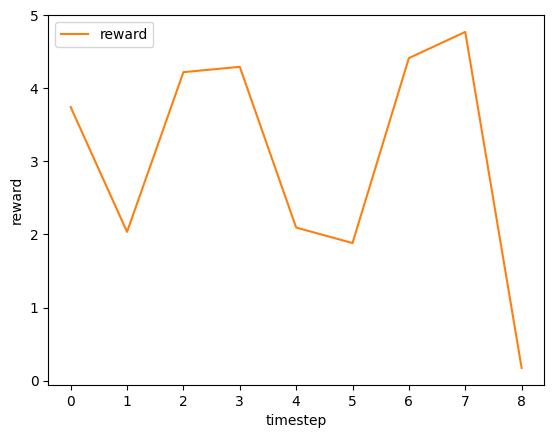

In [648]:
# let's visualize the transition of reward
def visualize_interaction_on_environment(env, agent):
    obs, info = env.reset()
    done = False
    reward_list = []

    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)
        reward_list.append(reward)

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
    ax1.set_xlabel('timestep')
    ax1.set_ylabel('reward')
    ax1.legend(loc='upper left')
    plt.show()
    
visualize_interaction_on_environment(env, agent)

## 2. Standardized Environment

We provide standardize syntheticenvironment

In [649]:
env = SyntheticEnv(random_state=12345)

## 3. Customize Environmental Configuration
Now, we customize the Simulation environment.

We have the following environmental configurations:
- `StateTransition`: State transition of the synthetic simulation.
- `RewardFunction`: Reward function of the synthetic simulation.
- `state_dim`: Dimensions of state.
- `action_type`: action type (i.e., continuous / discrete).
- `n_actions`: Number of actions. Applicable only when reward_type is "discrete".
- `action_dim`: Dimensions of the action context.
- `action_context`: Feature vectors that characterizes each action. Applicable only when reward_type is "discrete".
- `reward_type`: Reward type (i.e., continuous / binary).
- `reward_std`: Standard deviation of the reward distribution. Applicable only when reward_type is "continuous".
- `obs_std`: Standard deviation of the observation distribution.
- `step_per_episode`: Number of timesteps in an episode.
- `random_state` : Random state

#### Case 1. Customizing the Basic Setup

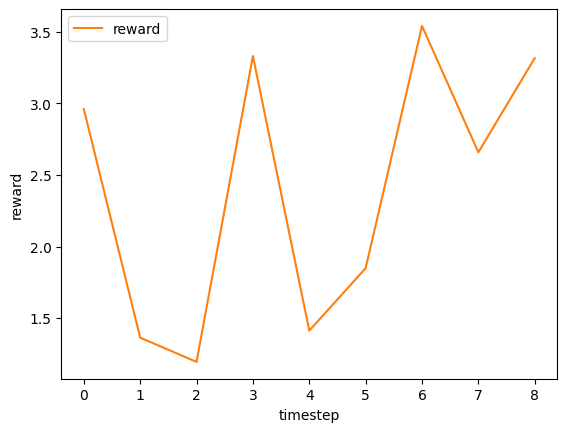

In [650]:
env = SyntheticEnv(
        StateTransition = StateTransition,
        RewardFunction = RewardFunction,
        state_dim = 10, # each state has 10 dimensional features
        action_type = "continuous",  # "discrete"
        action_dim = 5, # each action has 5 dimensional features
        action_context = None,
        reward_type = "continuous",  # we use continuous reward
        reward_std = 0.0, # not add noise to the reward
        obs_std = 0.0, # not add noise to the observation
        step_per_episode = 10,
        random_state = 12345,
)
agent.build_with_env(env)
visualize_interaction_on_environment(env, agent)

In [651]:
print(env.action_space)

Box(-0.1, 10.0, (5,), float64)


#### Case 2. Defining the action_context

In [652]:
# we use the following action_context for synthetic 
action_dim = 5
action_context =random_.normal(loc=0.0, scale=1.0, size=(action_dim, ))

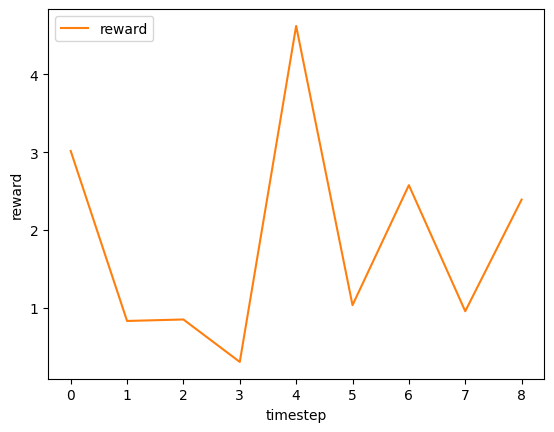

In [653]:
# using the above action_context, we can simulate an synthetic  as follows
env = SyntheticEnv(
        StateTransition = StateTransition,
        RewardFunction = RewardFunction,
        state_dim = 10,
        action_type = "continuous",  # "discrete"
        action_dim = action_dim,
        action_context = action_context, # user action_context defined above
        reward_type = "continuous",  # "binary"
        reward_std = 0.0,
        obs_std = 0.0,
        step_per_episode = 10,
        random_state = 12345,
)
agent.build_with_env(env)
visualize_interaction_on_environment(env, agent)

#### Case 3. Using Customized StateTransition

In [654]:
from syntheticgym import BaseStateTransition
from syntheticgym import Action

@dataclass
class StateTransition(BaseStateTransition):
    state_dim: int = 5
    action_type: str = "continuous",  # "discrete"
    action_dim: int = 3
    action_context: Optional[np.ndarray] = (None,)
    random_state: Optional[int] = None

    def __post_init__(self):
        self.random_ = check_random_state(self.random_state)
        self.state_coef = self.random_.normal(loc=0.0, scale=1.0, size=(self.state_dim, self.state_dim))
        self.action_coef = self.random_.normal(loc=0.0, scale=1.0, size=(self.state_dim, self.action_dim))

    def step(
        self,
        state: np.ndarray,
        action: Action,
    ) -> np.ndarray:
        
        if self.action_type == "continuous":
            state = self.state_coef @ state / self.state_dim +  self.action_coef @ action / self.action_dim
        
        elif self.action_type == "discrete":
            state = self.state_coef @ state / self.state_dim + self.action_coef @ self.action_context[action] / self.action_dim
            
        state = state / np.linalg.norm(state, ord=2)

        return state



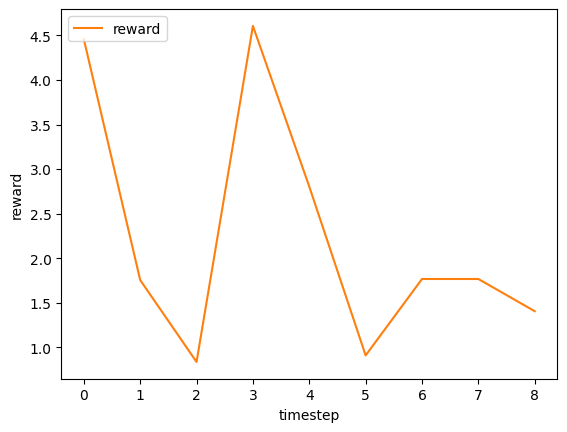

In [655]:
# setup environment
env = SyntheticEnv(
    StateTransition = StateTransition,
    random_state=12345
)
agent.build_with_env(env)
visualize_interaction_on_environment(env, agent)


#### Case 4. Using Customized RewardFunction

In [656]:
from syntheticgym import BaseRewardFunction
from syntheticgym import Action

@dataclass
class RewardFunction(BaseRewardFunction):
    reward_type: str = "continuous"  # "binary"
    reward_std: float = 0.0
    state_dim: int = 5
    action_type: str = "continuous",  # "discrete"
    action_dim: int = 3
    action_context: Optional[np.ndarray] = (None,)
    random_state: Optional[int] = None

    def __post_init__(self):
        check_scalar(
            self.reward_std,
            name="reward_std",
            target_type=float,
        )

        if self.reward_type not in ["continuous", "binary"]:
            raise ValueError(
                f'reward_type must be either "continuous" or "binary", but {self.reward_type} is given'
            )

        self.random_ = check_random_state(self.random_state)

        self.state_coef = self.random_.normal(loc=0.0, scale=1.0, size=(self.state_dim, ))
        self.action_coef = self.random_.normal(loc=0.0, scale=1.0, size=(self.action_dim, ))

    def sample(
        self,
        state: np.ndarray,
        action: Action,
    ) -> float:

        if self.action_type == "continuous":
            reward = self.state_coef.T @ state / self.state_dim + self.action_coef.T @ action / self.action_dim
        
        elif self.action_type == "discrete":
            reward = self.state_coef.T @ state / self.state_dim + self.action_coef.T @ self.action_context[action] / self.action_dim

        if self.reward_type == "continuous":
            reward = reward + self.random_.normal(loc=0.0, scale=self.reward_std)

        return reward


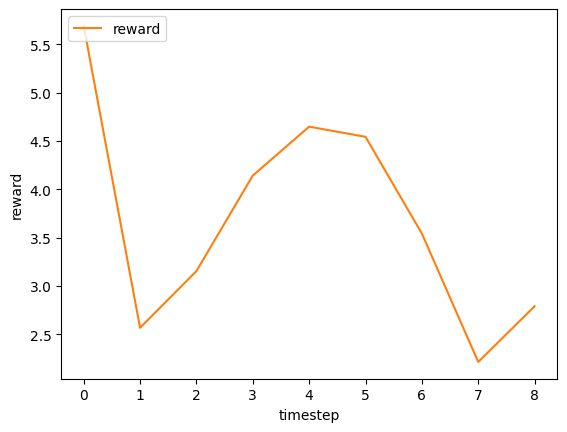

In [657]:
# setup environment
env = SyntheticEnv(
    RewardFunction = RewardFunction,
    random_state=12345
)
agent.build_with_env(env)
visualize_interaction_on_environment(env, agent)


#### Case 5. Defining Discrete Action Space

In [658]:
# let's customize the environment and discretize the action space
env = SyntheticEnv(
    action_type="discrete",
    random_state=random_state,
)

In [659]:
print(env.action_space)


Discrete(10)


In [660]:
# example
env = SyntheticEnv(
    action_type="discrete",
    n_actions=5,
    random_state=12345
)

In [661]:
print(env.action_space)
print(env.n_actions)

Discrete(5)
5


## Reference
- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.